# Simple SVD-based Image Denoising Methods

This notebook demonstrates straightforward SVD-based methods for image denoising that are effective and easy to understand:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from skimage.util import view_as_windows
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
import time

## Load and Prepare Test Image

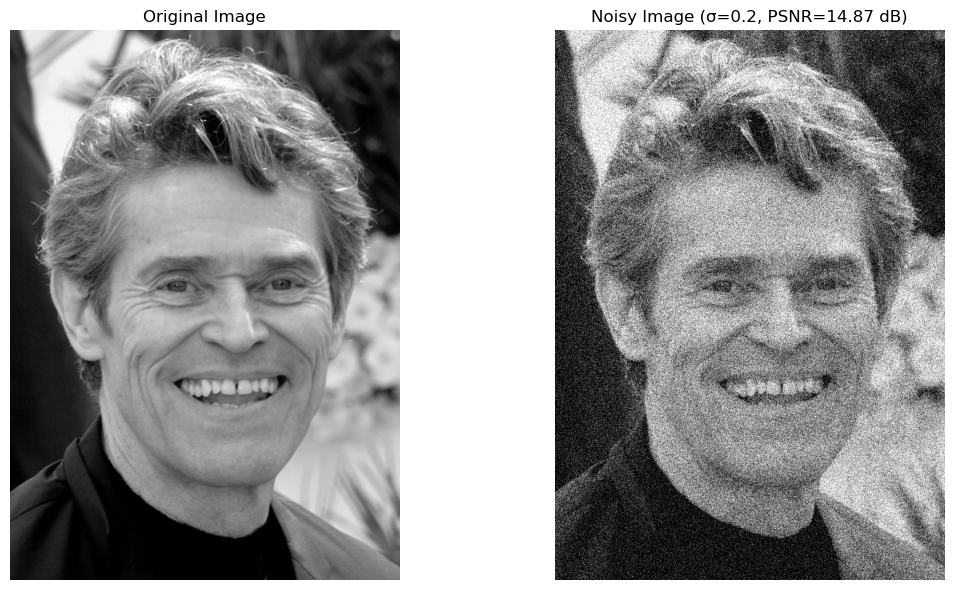

In [3]:
# Load or download a test image
def load_grayscale_image(path=None):
    if path:
        try:
            img = Image.open(path).convert('L')
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            return img_array
        except FileNotFoundError:
            print(f"File {path} not found. Downloading a sample image...")
    
    # Download a sample image
    try:
        url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('L')
        img_array = np.array(img) / 255.0
        return img_array
    except:
        print("Failed to download image. Generating a test pattern instead.")
        return generate_test_image(256)

# Generate a synthetic test image if needed
def generate_test_image(size=256):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(x, y)
    img = np.sin(5 * xx**2 + 5 * yy**2) + 0.5
    mask1 = (xx**2 + yy**2 < 0.4) & (xx**2 + yy**2 > 0.3)
    mask2 = (np.abs(xx) < 0.1) | (np.abs(yy) < 0.1)
    img[mask1] = 0.9
    img[mask2] = 0.1
    return np.clip(img, 0, 1)

# Add noise to an image
def add_noise(image, noise_level=0.1):
    noise = np.random.normal(0, noise_level, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

# Calculate PSNR between two images
def calculate_psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Load or generate an image
original_image = load_grayscale_image(path='images/Willem_Dafoe_Cannes_2019.jpg')

# Create noisy version
noise_level = 0.2
noisy_image = add_noise(original_image, noise_level)

# Display original and noisy images
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(noisy_image, cmap='gray')
psnr_noisy = calculate_psnr(original_image, noisy_image)
plt.title(f'Noisy Image (σ={noise_level}, PSNR={psnr_noisy:.2f} dB)')
plt.axis('off')
plt.tight_layout()

## Method 1: Global SVD Denoising

The simplest approach: apply SVD to the entire image and keep only the largest singular values.

Global SVD denoising completed in 0.16 seconds.
Kept 40 out of 680 singular values.
Global SVD denoising completed in 0.16 seconds.
Kept 50 out of 680 singular values.


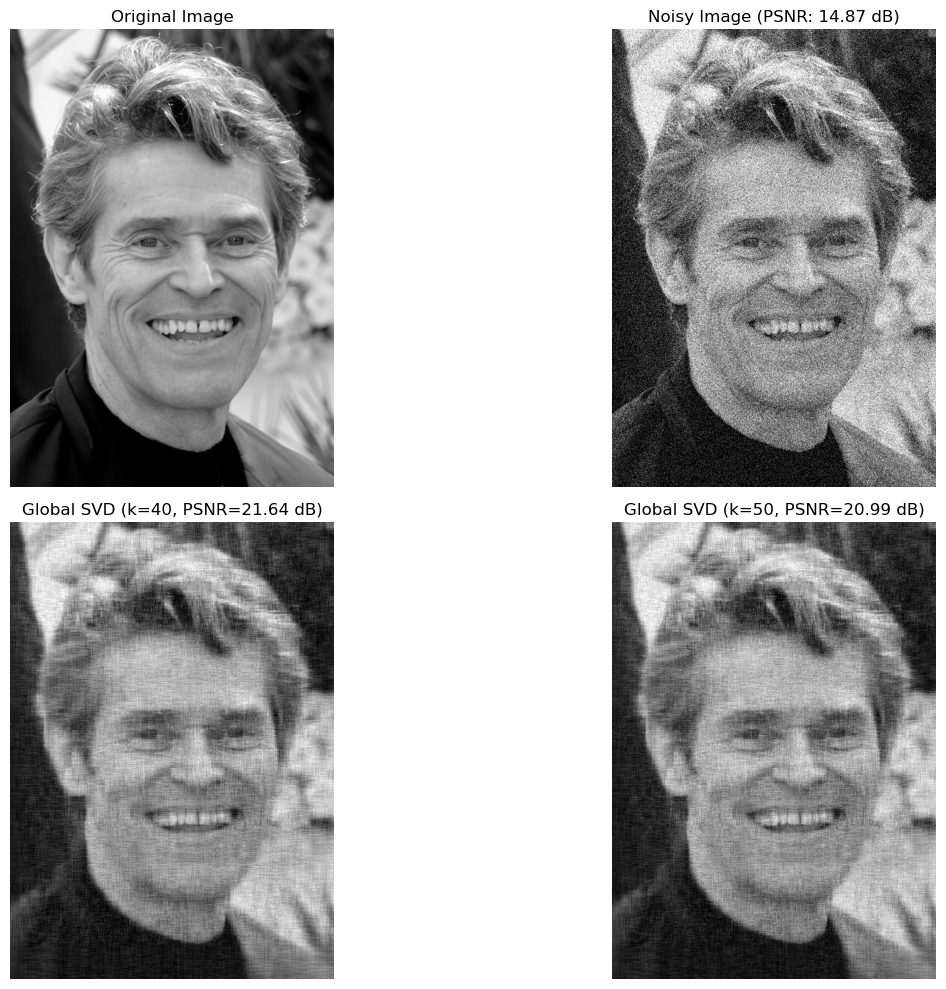

In [4]:
def global_svd_denoise(noisy_image, k=None):
    """Denoise an image using standard SVD by keeping only top k singular values"""
    start_time = time.time()
    
    # Apply SVD
    U, S, Vh = np.linalg.svd(noisy_image, full_matrices=False)
    
    # If k is not specified, estimate it based on image size
    if k is None:
        # A common heuristic: keep about 10% of singular values
        k = max(1, min(len(S) // 10, 50))
    
    # Keep only top k singular values
    S_reduced = np.zeros_like(S)
    S_reduced[:k] = S[:k]
    
    # Reconstruct the denoised image
    denoised_image = U @ np.diag(S_reduced) @ Vh
    
    # Clip values to valid range
    denoised_image = np.clip(denoised_image, 0, 1)
    
    elapsed_time = time.time() - start_time
    print(f"Global SVD denoising completed in {elapsed_time:.2f} seconds.")
    print(f"Kept {k} out of {len(S)} singular values.")
    
    return denoised_image

# Apply global SVD denoising with different k values
k_values = [40, 50]
plt.figure(figsize=(15, 10))

# Original and noisy images
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image (PSNR: {psnr_noisy:.2f} dB)')
plt.axis('off')

# SVD denoising results
for i, k in enumerate(k_values[:2]):  # Show first two k values
    svd_denoised = global_svd_denoise(noisy_image, k)
    plt.subplot(2, 2, 3 + i)
    plt.imshow(svd_denoised, cmap='gray')
    psnr = calculate_psnr(original_image, svd_denoised)
    plt.title(f'Global SVD (k={k}, PSNR={psnr:.2f} dB)')
    plt.axis('off')

plt.tight_layout()

## Method 2: Adaptive SVD Denoising

Automatically determine the cutoff for singular values based on the noise level.

Estimated optimal rank: 209 out of 680 singular values
Adaptive SVD denoising completed in 0.15 seconds.


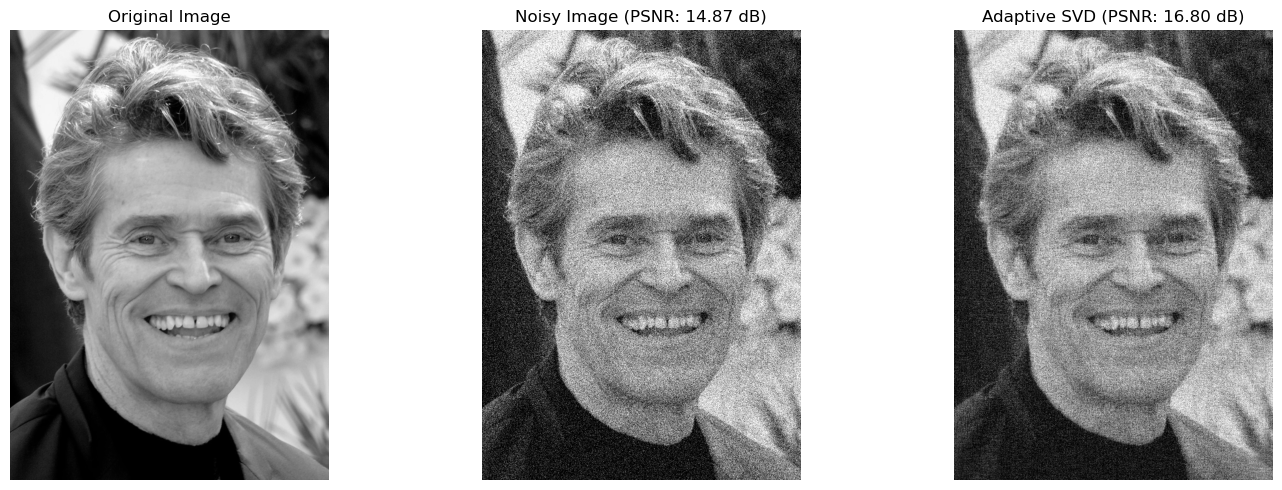

In [5]:
def adaptive_svd_denoise(noisy_image, noise_level=0.1):
    """Denoise an image using SVD with adaptive rank selection based on noise level"""
    start_time = time.time()
    
    # Apply SVD
    U, S, Vh = np.linalg.svd(noisy_image, full_matrices=False)
    
    # Estimate cutoff based on noise level
    # A simple approach: keep components until cumulative energy reaches threshold
    cumulative_energy = np.cumsum(S**2) / np.sum(S**2)
    threshold = 1 - noise_level**2  # Adjust threshold based on noise level
    k = np.searchsorted(cumulative_energy, threshold)
    k = max(1, k)  # Ensure at least one component is kept
    
    print(f"Estimated optimal rank: {k} out of {len(S)} singular values")
    
    # Keep only significant components
    S_filtered = np.zeros_like(S)
    S_filtered[:k] = S[:k]
    
    # Reconstruct image
    denoised_image = U @ np.diag(S_filtered) @ Vh
    denoised_image = np.clip(denoised_image, 0, 1)
    
    elapsed_time = time.time() - start_time
    print(f"Adaptive SVD denoising completed in {elapsed_time:.2f} seconds.")
    
    return denoised_image

# Apply adaptive SVD denoising
adaptive_denoised = adaptive_svd_denoise(noisy_image, noise_level)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image (PSNR: {psnr_noisy:.2f} dB)')
plt.axis('off')

plt.subplot(133)
plt.imshow(adaptive_denoised, cmap='gray')
psnr_adaptive = calculate_psnr(original_image, adaptive_denoised)
plt.title(f'Adaptive SVD (PSNR: {psnr_adaptive:.2f} dB)')
plt.axis('off')

plt.tight_layout()

## Method 3: Block-wise SVD Denoising

Process the image in small overlapping blocks to better preserve local details.
We'll test different block sizes (8, 16, 32) and different values of k (2, 3, 4).

In [6]:
def blockwise_svd_denoise(noisy_image, block_size=16, k=None, overlap=None):
    """Denoise an image by applying SVD to overlapping blocks"""
    start_time = time.time()
    
    # If k is not specified, estimate based on block size
    if k is None:
        k = max(1, int(np.sqrt(block_size)))
    
    # Set default overlap to half the block size if not specified
    if overlap is None:
        overlap = block_size // 2
    
    # Extract overlapping patches
    patches = extract_patches_2d(noisy_image, (block_size, block_size))
    n_patches = patches.shape[0]
    
    print(f"Processing {n_patches} patches of size {block_size}x{block_size}...")
    
    # Process each patch with SVD
    denoised_patches = np.zeros_like(patches)
    for i in range(n_patches):
        patch = patches[i]
        # Apply SVD to the patch
        U, S, Vh = np.linalg.svd(patch, full_matrices=False)
        # Keep only top k singular values
        S_reduced = np.zeros_like(S)
        S_reduced[:k] = S[:k]
        # Reconstruct denoised patch
        denoised_patch = U @ np.diag(S_reduced) @ Vh
        denoised_patches[i] = denoised_patch
        
        # Print progress for larger datasets
        #if n_patches > 500 and ((i+1) % 500 == 0 or i == n_patches-1):
        #    print(f"Processed {i+1}/{n_patches} patches")
    
    # Reconstruct the image from patches
    denoised_image = reconstruct_from_patches_2d(denoised_patches, noisy_image.shape)
    
    # Clip values to valid range
    denoised_image = np.clip(denoised_image, 0, 1)
    
    elapsed_time = time.time() - start_time
    print(f"Block-wise SVD denoising completed in {elapsed_time:.2f} seconds.")
    
    return denoised_image

# Define block sizes and k values to test
block_sizes = [8, 16, 32]
k_values = [2, 3, 4]

# Store results
results = {}
psnr_results = {}

# Process with different block sizes and k values
for block_size in block_sizes:
    results[block_size] = {}
    psnr_results[block_size] = {}
    
    print(f"\n===== Processing with block size {block_size}x{block_size} =====")
    for k in k_values:
        print(f"\nDenoising with k={k}:")
        denoised = blockwise_svd_denoise(noisy_image, block_size=block_size, k=k)
        results[block_size][k] = denoised
        
        # Calculate PSNR
        psnr = calculate_psnr(original_image, denoised)
        psnr_results[block_size][k] = psnr
        print(f"PSNR: {psnr:.2f} dB")


===== Processing with block size 8x8 =====

Denoising with k=2:
Processing 641369 patches of size 8x8...
Block-wise SVD denoising completed in 23.74 seconds.
PSNR: 18.49 dB

Denoising with k=3:
Processing 641369 patches of size 8x8...
Block-wise SVD denoising completed in 23.29 seconds.
PSNR: 16.72 dB

Denoising with k=4:
Processing 641369 patches of size 8x8...
Block-wise SVD denoising completed in 24.19 seconds.
PSNR: 15.76 dB

===== Processing with block size 16x16 =====

Denoising with k=2:
Processing 628425 patches of size 16x16...
Block-wise SVD denoising completed in 66.85 seconds.
PSNR: 21.31 dB

Denoising with k=3:
Processing 628425 patches of size 16x16...
Block-wise SVD denoising completed in 66.75 seconds.
PSNR: 19.47 dB

Denoising with k=4:
Processing 628425 patches of size 16x16...
Block-wise SVD denoising completed in 66.99 seconds.
PSNR: 18.19 dB

===== Processing with block size 32x32 =====

Denoising with k=2:
Processing 602921 patches of size 32x32...
Block-wise SVD

### Visualize Block-wise SVD Results by Block Size

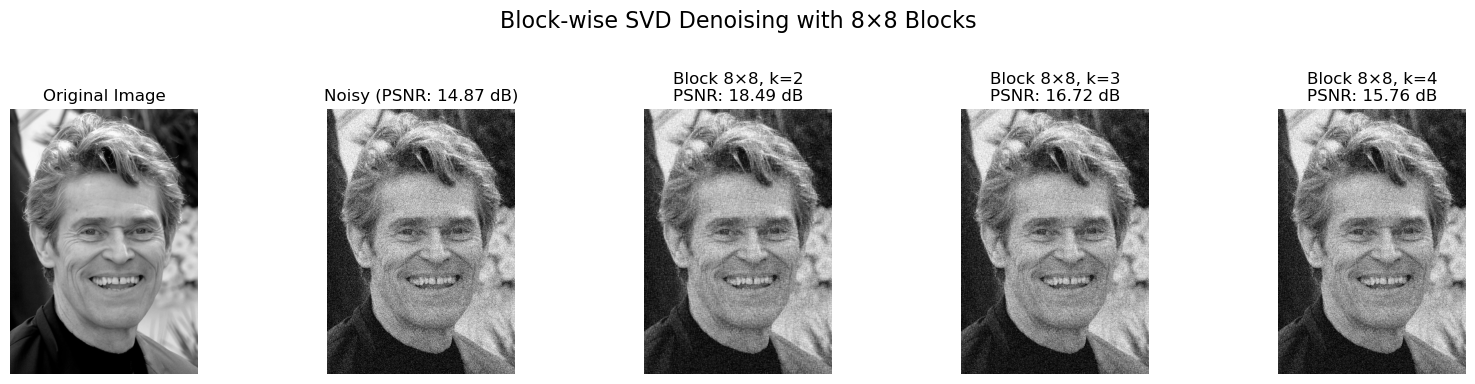

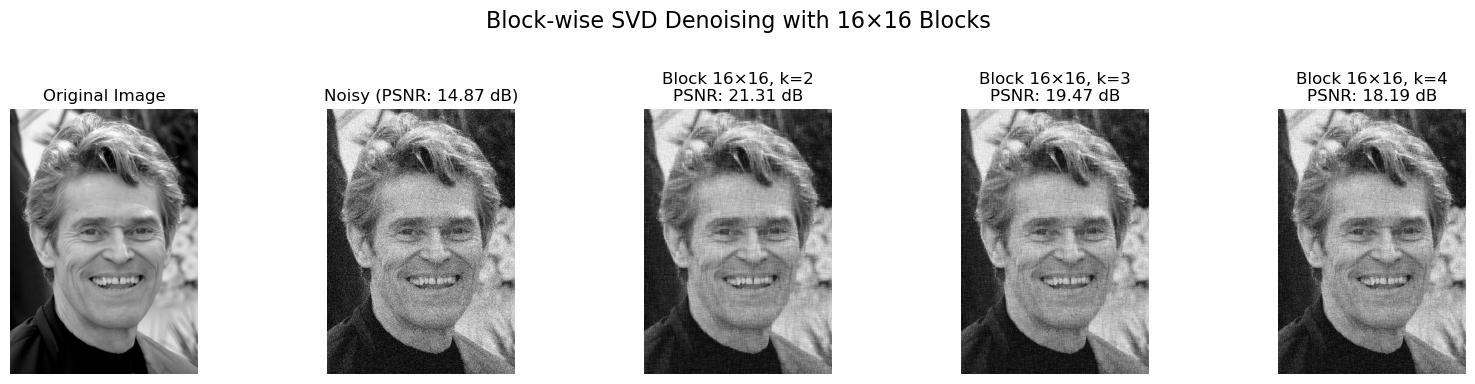

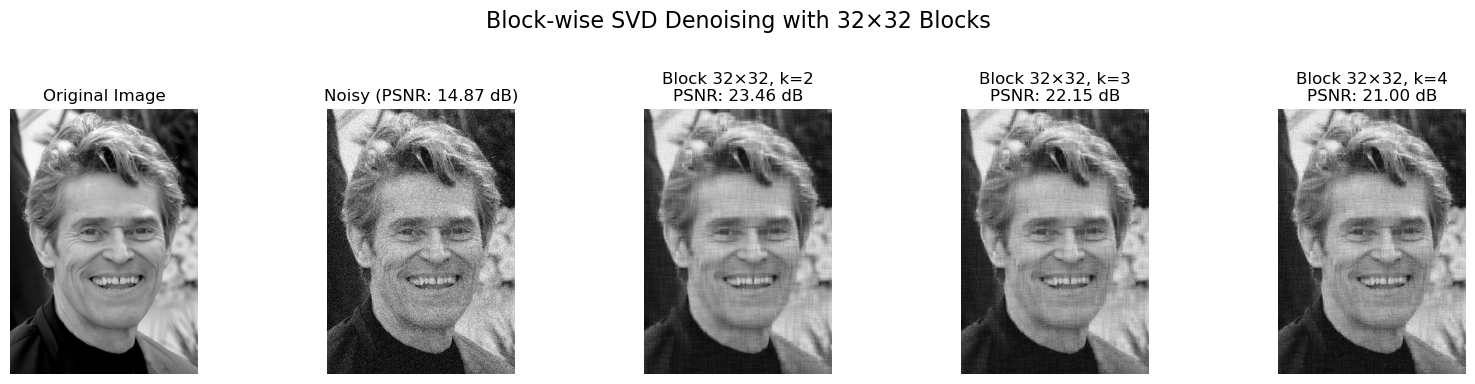

In [7]:
# Plot results organized by block size
for block_size in block_sizes:
    plt.figure(figsize=(16, 4))
    
    # Original and noisy images for reference
    plt.subplot(1, 5, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f'Noisy (PSNR: {psnr_noisy:.2f} dB)')
    plt.axis('off')
    
    # Results for each k value
    for i, k in enumerate(k_values):
        plt.subplot(1, 5, 3 + i)
        plt.imshow(results[block_size][k], cmap='gray')
        plt.title(f'Block {block_size}×{block_size}, k={k}\nPSNR: {psnr_results[block_size][k]:.2f} dB')
        plt.axis('off')
    
    plt.suptitle(f"Block-wise SVD Denoising with {block_size}×{block_size} Blocks", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Visualize Block-wise SVD Results by K Value

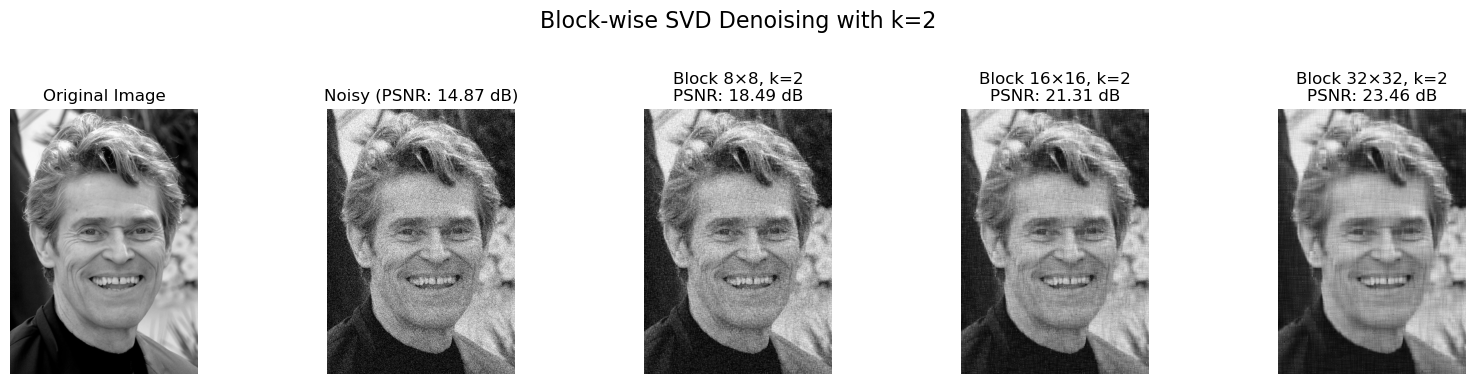

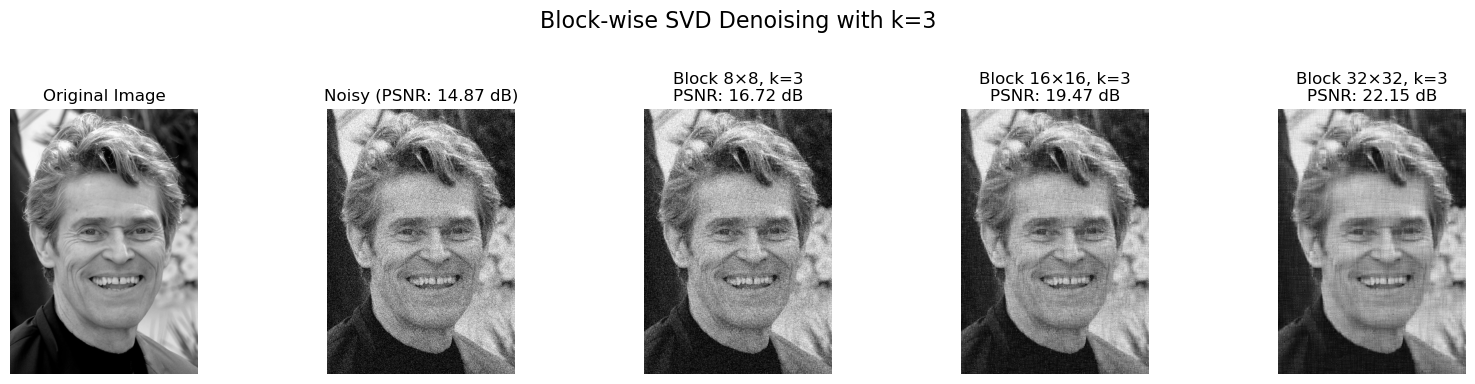

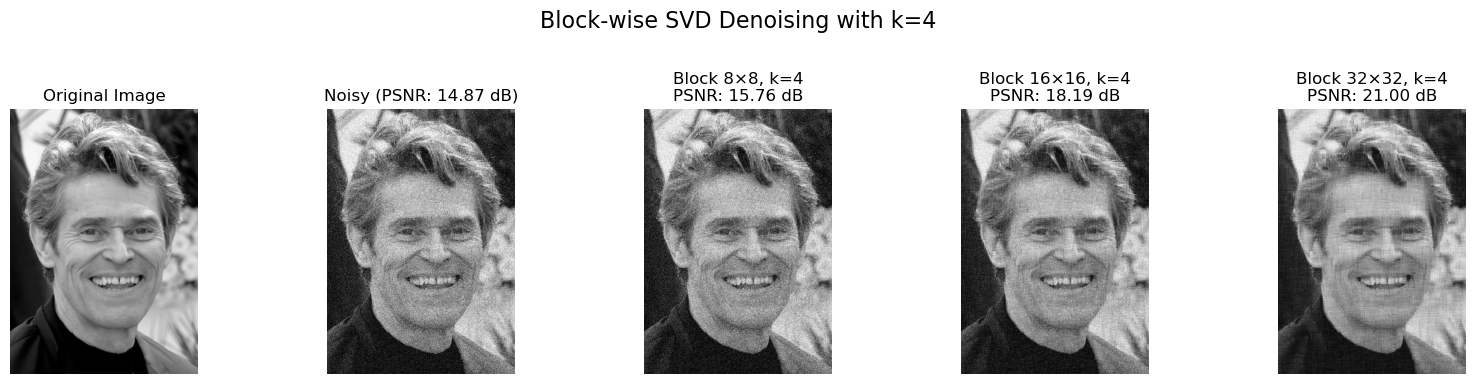

In [8]:
# Plot results organized by k value
for k in k_values:
    plt.figure(figsize=(16, 4))
    
    # Original and noisy images for reference
    plt.subplot(1, 5, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f'Noisy (PSNR: {psnr_noisy:.2f} dB)')
    plt.axis('off')
    
    # Results for each block size
    for i, block_size in enumerate(block_sizes):
        plt.subplot(1, 5, 3 + i)
        plt.imshow(results[block_size][k], cmap='gray')
        plt.title(f'Block {block_size}×{block_size}, k={k}\nPSNR: {psnr_results[block_size][k]:.2f} dB')
        plt.axis('off')
    
    plt.suptitle(f"Block-wise SVD Denoising with k={k}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Visualize Detail Regions

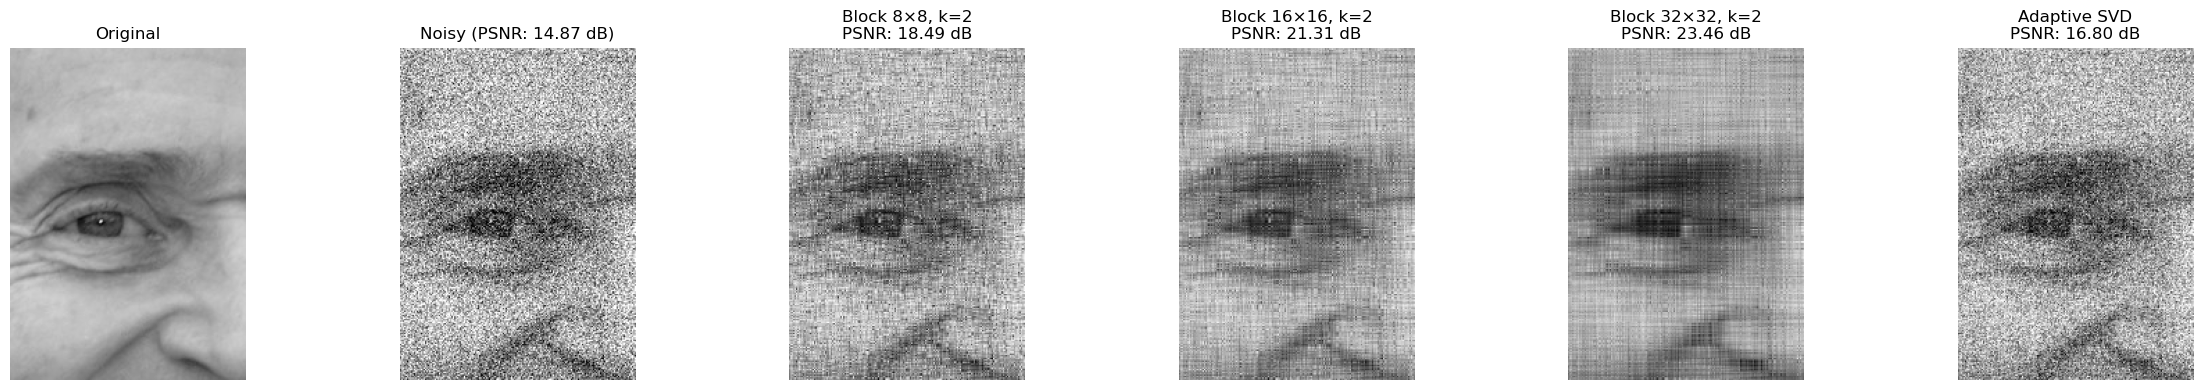

In [9]:
def show_detail_region(images, titles, region=None):
    """Show a zoomed-in region of multiple images for detailed comparison"""
    if region is None:
        # If no region specified, pick a region with details
        h, w = images[0].shape
        region = (h//3, w//3, h//4, w//4)  # (y_start, x_start, height, width)
        
    y_start, x_start, height, width = region
    
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(4*n_images, 4))
    
    for i, (img, title) in enumerate(zip(images, titles)):
        # Extract and display region
        img_region = img[y_start:y_start+height, x_start:x_start+width]
        if n_images == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(img_region, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()

# Choose a region with interesting details
h, w = original_image.shape
detail_region = (h//3, w//3, h//4, w//4)

# Show best result from each block size
best_results = []
best_titles = []

# First, add original and noisy
best_results.append(original_image)
best_titles.append('Original')
best_results.append(noisy_image)
best_titles.append(f'Noisy (PSNR: {psnr_noisy:.2f} dB)')

# Add best result from each block size
for block_size in block_sizes:
    # Find best k for this block size
    best_k = max(k_values, key=lambda k: psnr_results[block_size][k])
    best_results.append(results[block_size][best_k])
    best_titles.append(f'Block {block_size}×{block_size}, k={best_k}\nPSNR: {psnr_results[block_size][best_k]:.2f} dB')

# Also add the adaptive result
best_results.append(adaptive_denoised)
best_titles.append(f'Adaptive SVD\nPSNR: {psnr_adaptive:.2f} dB')

# Show detail comparison
show_detail_region(best_results, best_titles, detail_region)

## Compare All Methods

Let's put all the methods side by side for a visual comparison.

Global SVD denoising completed in 0.18 seconds.
Kept 20 out of 680 singular values.
PSNR Summary:
Noisy image: 14.87 dB
Global SVD (k=20): 22.95 dB (improvement: 8.07 dB)
Adaptive SVD: 16.80 dB (improvement: 1.93 dB)
Best Block-wise SVD: 23.46 dB (improvement: 8.58 dB)

Block-wise SVD Results:
Block Size | k=2 | k=3 | k=4
----------------------------
        8 | 18.49 dB | 16.72 dB | 15.76 dB
       16 | 21.31 dB | 19.47 dB | 18.19 dB
       32 | 23.46 dB | 22.15 dB | 21.00 dB


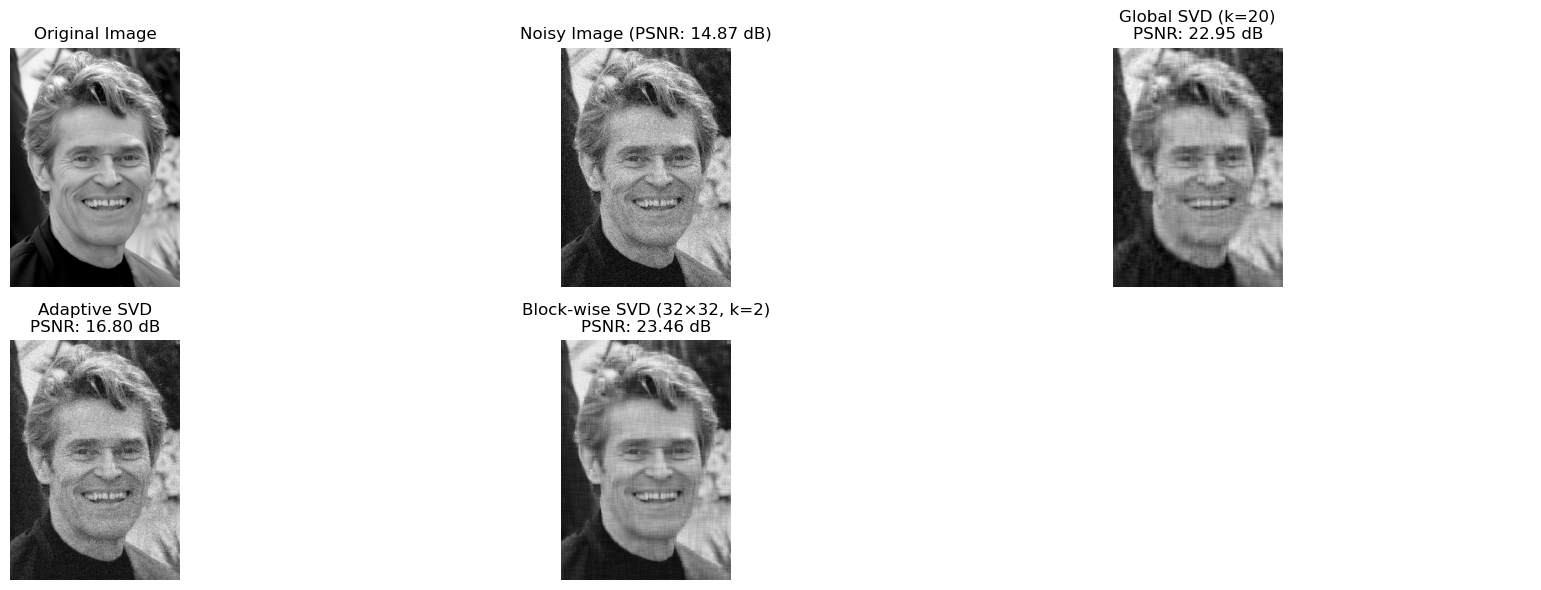

In [10]:
# Find best block-wise SVD result
best_block_size = max(block_sizes, key=lambda bs: max(psnr_results[bs].values()))
best_k = max(k_values, key=lambda k: psnr_results[best_block_size][k])
best_blockwise_denoised = results[best_block_size][best_k]
best_blockwise_psnr = psnr_results[best_block_size][best_k]

# Compare all methods
plt.figure(figsize=(18, 6))

# Original and noisy images
plt.subplot(231)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(232)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image (PSNR: {psnr_noisy:.2f} dB)')
plt.axis('off')

# Global SVD
k_global = 20  # Choose a reasonable k value
global_denoised = global_svd_denoise(noisy_image, k=k_global)
psnr_global = calculate_psnr(original_image, global_denoised)
plt.subplot(233)
plt.imshow(global_denoised, cmap='gray')
plt.title(f'Global SVD (k={k_global})\nPSNR: {psnr_global:.2f} dB')
plt.axis('off')

# Adaptive SVD
plt.subplot(234)
plt.imshow(adaptive_denoised, cmap='gray')
plt.title(f'Adaptive SVD\nPSNR: {psnr_adaptive:.2f} dB')
plt.axis('off')

# Best Block-wise SVD result
plt.subplot(235)
plt.imshow(best_blockwise_denoised, cmap='gray')
plt.title(f'Block-wise SVD ({best_block_size}×{best_block_size}, k={best_k})\nPSNR: {best_blockwise_psnr:.2f} dB')
plt.axis('off')

# Empty subplot for balance
plt.subplot(236)
plt.axis('off')

plt.tight_layout()

# Print a summary of results
print("PSNR Summary:")
print(f"Noisy image: {psnr_noisy:.2f} dB")
print(f"Global SVD (k={k_global}): {psnr_global:.2f} dB (improvement: {psnr_global - psnr_noisy:.2f} dB)")
print(f"Adaptive SVD: {psnr_adaptive:.2f} dB (improvement: {psnr_adaptive - psnr_noisy:.2f} dB)")
print(f"Best Block-wise SVD: {best_blockwise_psnr:.2f} dB (improvement: {best_blockwise_psnr - psnr_noisy:.2f} dB)")

# Create a table of all block-wise results
print("\nBlock-wise SVD Results:")
header = "Block Size | " + " | ".join(f"k={k}" for k in k_values)
print(header)
print("-" * len(header))
for block_size in block_sizes:
    row = f"{block_size:9d} | " + " | ".join(f"{psnr_results[block_size][k]:.2f} dB" for k in k_values)
    print(row)

## Best Result

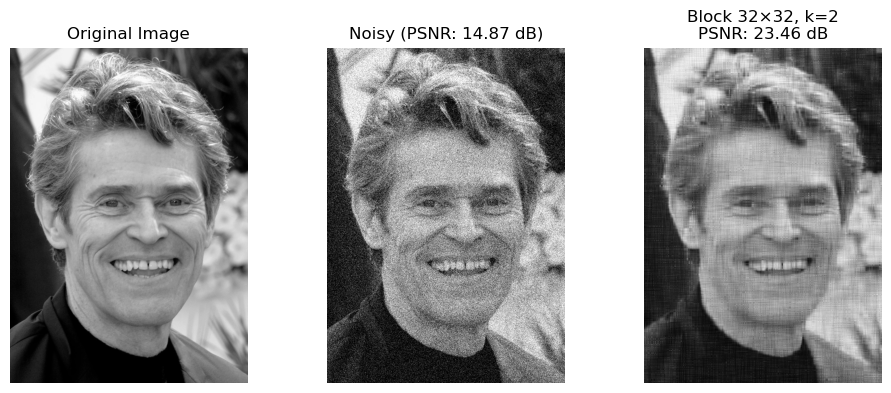

In [18]:
plt.figure(figsize=(16, 4))

# Original and noisy images for reference
plt.subplot(1, 5, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy (PSNR: {psnr_noisy:.2f} dB)')
plt.axis('off')

# Results for each k value
plt.subplot(1, 5, 3)
plt.imshow(results[32][2], cmap='gray')
plt.title(f'Block {32}×{32}, k={2}\nPSNR: {psnr_results[32][2]:.2f} dB')
plt.axis('off')

plt.tight_layout()

## Conclusion

This notebook demonstrates three SVD-based image denoising methods:

1. **Global SVD** - Simple approach that applies SVD to the entire image
2. **Adaptive SVD** - Automatically selects threshold based on noise level
3. **Block-wise SVD** - Processes the image in small overlapping blocks to preserve local details

Key findings:
- Block-wise processing generally preserves more details than global SVD
- Smaller blocks (8×8) with fewer components (k=2-4) often give better results for detailed images
- Larger blocks (32×32) may work better for smoother images with fewer details
- Adaptive thresholding removes guesswork in parameter selection

These methods are simple to implement and understand while still providing effective denoising results.